In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Import local modules
import xrd
import helpers as h
from model_common import XRDRegressor, NormalizedXRDDataset, denorm_params, RANGES, PARAM_NAMES, get_device
from importlib import reload

# Reload modules to get latest changes
reload(xrd)
reload(h)

print("✅ Imports successful")
print(f"Parameters to predict: {PARAM_NAMES}")

✅ Imports successful
Parameters to predict: ['Dmax1', 'D01', 'L1', 'Rp1', 'D02', 'L2', 'Rp2']


## Configuration

In [2]:
# Paths
EXPERIMENT_FILE = "experiment.txt"
MODEL_CHECKPOINT = "checkpoints/dataset_1000_dl100_7d_v3.pt"

# Model expects 650 points (m1_ML from xrd.py)
EXPECTED_LENGTH = 650

# Device
device = get_device()
print(f"Using device: {device}")

✓ Using MPS (Apple Silicon)
Using device: mps


## 1. Load Experimental Data

In [3]:
def load_experimental_data(file_path):
    """
    Load experimental XRD data from text file.
    Handles European decimal format (comma instead of dot).
    
    Returns:
        np.ndarray: Intensity values
    """
    intensities = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            # Split by arrow if present
            if '→' in line:
                _, value = line.split('→')
            else:
                value = line
            
            # Replace comma with dot for European format
            value = value.replace(',', '.')
            
            try:
                intensities.append(float(value))
            except ValueError:
                print(f"Warning: Could not parse line: {line}")
                continue
    
    return np.array(intensities)


# Load data
exp_data = load_experimental_data(EXPERIMENT_FILE)
print(f"✅ Loaded {len(exp_data)} data points from experiment.txt")
print(f"Data range: {exp_data.min():.2e} to {exp_data.max():.2e}")

✅ Loaded 360 data points from experiment.txt
Data range: 1.94e-04 to 8.00e-02


## 2. Plot Raw Experimental Data

In [ ]:
r_curve, r_profile = xrd.compute_curve_and_profile(
    array=[0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8],
    dl=100e-8
)

/var/folders/jk/xsnyxvks5ts_232t26nlcr400000gn/T/ipykernel_98267/1086133141.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(r_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Full data', color='orange')


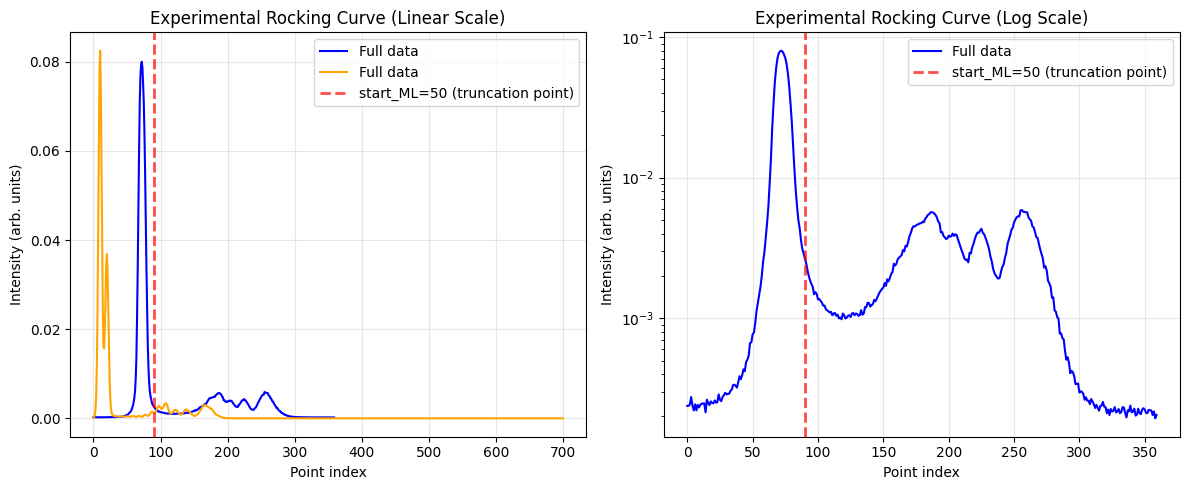

Peak position: index 72
Peak intensity: 8.0000e-02
Truncation point (start_ML): 50
Points used for ML: 310 (will be interpolated to 650)


In [5]:
plt.figure(figsize=(12, 5))

# Linear scale
plt.subplot(1, 2, 1)
plt.plot(exp_data, 'b-', linewidth=1.5, label='Full data')
plt.plot(r_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Full data', color='orange')
plt.axvline(x=90, color='r', linestyle='--', linewidth=2, alpha=0.7, label='start_ML=50 (truncation point)')
plt.xlabel('Point index')
plt.ylabel('Intensity (arb. units)')
plt.title('Experimental Rocking Curve (Linear Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

# Log scale
plt.subplot(1, 2, 2)
plt.semilogy(exp_data, 'b-', linewidth=1.5, label='Full data')
plt.axvline(x=90, color='r', linestyle='--', linewidth=2, alpha=0.7, label='start_ML=50 (truncation point)')
plt.xlabel('Point index')
plt.ylabel('Intensity (arb. units)')
plt.title('Experimental Rocking Curve (Log Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

peak_idx = np.argmax(exp_data)
print(f"Peak position: index {peak_idx}")
print(f"Peak intensity: {exp_data.max():.4e}")
print(f"Truncation point (start_ML): 50")
print(f"Points used for ML: {len(exp_data) - 50} (will be interpolated to 650)")

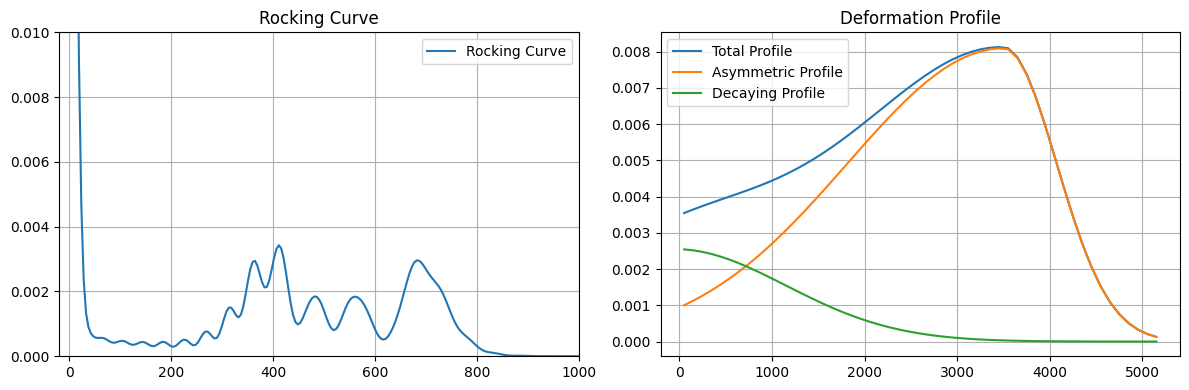

In [6]:
test_params = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]
t_curve, t_profile = xrd.compute_curve_and_profile(array=test_params)

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 12 width, 4 height

axes[0].set_title("Rocking Curve")
# axes[0].plot(t_curve.X_DeltaTeta, np.log(t_curve.Y_R_vseZ), label="Rocking Curve")
axes[0].plot(t_curve.X_DeltaTeta, t_curve.Y_R_vseZ, label="Rocking Curve")
axes[0].set_ylim(0, 0.01)
axes[0].set_xlim(-20, 1000)
axes[0].grid(True)
axes[0].legend()

axes[1].set_title("Deformation Profile")
axes[1].plot(t_profile.X, t_profile.total_Y, label="Total Profile")
axes[1].plot(t_profile.X, t_profile.asymmetric_Y, label="Asymmetric Profile")
axes[1].plot(t_profile.X, t_profile.decaying_Y, label="Decaying Profile")
# axes[1].set_ylim(0, 0.02)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Preprocess Data for Model

The model expects:
- **Input**: 650 points (tail region only, without main peak)
- **Preprocessing**: Log10-normalized to [0, 1]
- **Shape**: [1, 1, 650] (batch, channels, length)

### Important: Truncation Logic

Training data generation in `xrd.py` uses:
```python
start_ML = 50  # Skip first 50 points (peak region)
m1 = 700       # Total points
R_vseZ_ML = R_vseZ[start_ML:m1]  # Take points [50:700] = 650 points
```

This means the model was trained **only on the tail region** after skipping the main Bragg peak. The tail contains information about the deformation profile in the defected layer.

We apply the **exact same logic** to experimental data:
1. Skip first 50 points
2. Take remaining points as tail
3. Interpolate to 650 points if needed

In [7]:
def preprocess_for_model(
    data: np.ndarray,
    start_ML: int = 50,
    target_length: int = 650,
    torch_dtype: torch.dtype = torch.float32
) -> torch.Tensor:
    """
    1) Skip first `start_ML` points
    2) Take the rest (tail)
    3) If needed, pad on the right with zeros to `target_length`
    4) Return as torch tensor
    """
    n = len(data)
    print(f"Total data points: {n}")
    if n <= start_ML:
        raise ValueError(f"Data too short! Has {n} points, need at least {start_ML+1}")

    # Use float64 in NumPy to avoid precision loss during slicing/padding/printing
    tail = np.asarray(data[start_ML:], dtype=np.float64)
    print(f"After skipping first {start_ML} points: {len(tail)} points remaining")

    if len(tail) == target_length:
        processed = tail
        print(f"✅ Exact match: {target_length} points")
    elif len(tail) > target_length:
        processed = tail[:target_length]
        print(f"Truncated from {len(tail)} to {target_length} points")
    else:
        pad_right = target_length - len(tail)
        processed = np.pad(tail, (0, pad_right), mode='constant', constant_values=0.0)
        print(f"Padded on right with {pad_right} zeros → {processed.shape}")

    # High-precision peek so you can verify values aren’t all the same
    print("Last 10 (scientific, 8 sig figs):")
    print(np.array2string(processed[-10:], formatter={'float_kind': lambda x: f"{x:.8e}"}))

    # Convert to torch
    t = torch.from_numpy(processed).to(dtype=torch_dtype)
    return t

# Preprocess experimental data
exp_data_processed = preprocess_for_model(exp_data, start_ML=90, target_length=EXPECTED_LENGTH)
print(f"\n✅ Preprocessed data shape: {exp_data_processed.shape}")
print(f"Data range after normalization: {exp_data_processed.min():.4f} to {exp_data_processed.max():.4f}")

Total data points: 360
After skipping first 90 points: 270 points remaining
Padded on right with 380 zeros → (650,)
Last 10 (scientific, 8 sig figs):
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]

✅ Preprocessed data shape: torch.Size([650])
Data range after normalization: 0.0000 to 0.0059


In [8]:
print(exp_data[350:], exp_data_processed[260:270])

[0.000224 0.000212 0.000211 0.000223 0.000221 0.000221 0.000205 0.000217
 0.000194 0.000205] tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002])


## 4. Load Trained Model

In [9]:
# Load model checkpoint
if not Path(MODEL_CHECKPOINT).exists():
    raise FileNotFoundError(f"Model checkpoint not found: {MODEL_CHECKPOINT}")

checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"✅ Loaded checkpoint from {MODEL_CHECKPOINT}")
print(f"Checkpoint contains: {list(checkpoint.keys())}")

# Initialize model
model = XRDRegressor().to(device)
model.load_state_dict(checkpoint['model'])
# model.eval()  # Set to evaluation mode

print(f"✅ Model loaded and ready for inference")
print(f"Model output dimension: {7} parameters")

✅ Loaded checkpoint from checkpoints/dataset_1000_dl100_7d_v3.pt
Checkpoint contains: ['model', 'L', 'epoch', 'val_loss']
✅ Model loaded and ready for inference
Model output dimension: 7 parameters


## 5. Make Predictions

In [10]:
m1_ML = exp_data_processed.size()[0]
parsed_X = torch.tensor(np.linspace(0, m1_ML - 1, m1_ML)).unsqueeze(0)
parsed_Y = exp_data_processed.unsqueeze(0)

# ds = NormalizedXRDDataset(parsed_X, parsed_Y, train=False)
ds = NormalizedXRDDataset(parsed_X, torch.tensor(r_curve.Y_R_vseZ, dtype=torch.float32).unsqueeze(0), train=False)
dl = torch.utils.data.DataLoader(ds, batch_size=256)

preds = []
with torch.no_grad():
    for y, _ in dl:
        p = model(y.to(device))
        preds.append(p.to(device))
P = torch.cat(preds, dim=0)
Theta_hat = denorm_params(P)

In [11]:
exp_data_processed.size()[0]

650

In [12]:
P

tensor([[0.2663, 0.0801, 0.5886, 0.4434, 0.5485, 0.3409, 0.5879]],
       device='mps:0')

In [13]:
preds

[tensor([[0.2663, 0.0801, 0.5886, 0.4434, 0.5485, 0.3409, 0.5879]],
        device='mps:0')]

## 6. Visualize Predicted Deformation Profile

Using the predicted parameters, compute the theoretical curve and deformation profile.

In [14]:
pred_values = Theta_hat[0]

In [15]:
pred_values

tensor([ 8.9901e-03,  2.9024e-03,  4.3261e-05,  2.2671e-05,  1.7456e-02,
         2.0340e-05, -2.6789e-05], device='mps:0')

In [16]:
# Compute theoretical curve and profile using predicted parameters
curve, profile = xrd.compute_curve_and_profile(array=pred_values.cpu().numpy())

print(f"✅ Computed theoretical curve ({len(curve.ML_Y)} points)")
print(f"✅ Computed deformation profile ({len(profile.total_Y)} layers)")

✅ Computed theoretical curve (650 points)
✅ Computed deformation profile (43 layers)


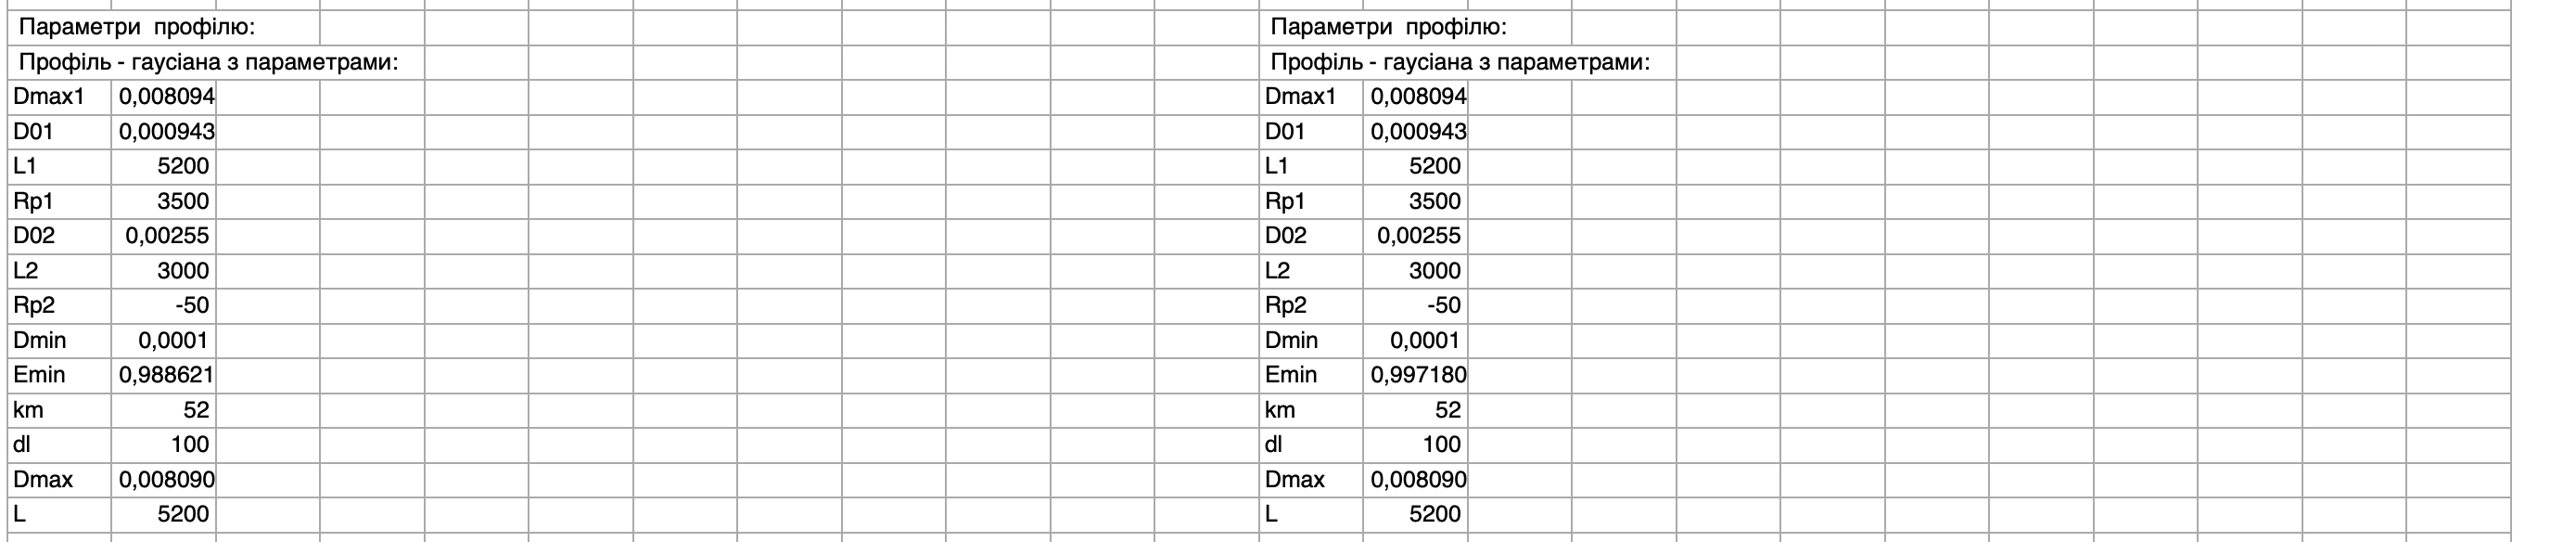

In [17]:
parsed_Y.numpy()

array([[0.00266 , 0.00246 , 0.00219 , 0.00199 , 0.00185 , 0.00175 ,
        0.00167 , 0.00148 , 0.00153 , 0.00149 , 0.00136 , 0.00137 ,
        0.00133 , 0.00129 , 0.00123 , 0.00123 , 0.00116 , 0.00114 ,
        0.00112 , 0.0011  , 0.00111 , 0.00105 , 0.00108 , 0.00109 ,
        0.00104 , 0.00106 , 0.000998, 0.00101 , 0.000983, 0.00108 ,
        0.00105 , 0.000996, 0.00101 , 0.00104 , 0.00105 , 0.00102 ,
        0.00108 , 0.00109 , 0.00105 , 0.00108 , 0.00107 , 0.00104 ,
        0.00105 , 0.00114 , 0.00106 , 0.00108 , 0.0012  , 0.0012  ,
        0.00129 , 0.00128 , 0.00121 , 0.00124 , 0.00126 , 0.00135 ,
        0.00132 , 0.00138 , 0.00145 , 0.00152 , 0.00157 , 0.00162 ,
        0.00165 , 0.00178 , 0.0017  , 0.00189 , 0.00183 , 0.00193 ,
        0.00207 , 0.00213 , 0.00244 , 0.00237 , 0.00244 , 0.00263 ,
        0.00269 , 0.00276 , 0.00281 , 0.00305 , 0.00299 , 0.00328 ,
        0.00324 , 0.0035  , 0.00383 , 0.00404 , 0.00434 , 0.00451 ,
        0.00449 , 0.00457 , 0.00464 , 0.00467 , 

In [18]:
curve.ML_Y

array([4.21296005e-04, 4.07049057e-04, 3.95443391e-04, 3.87569459e-04,
       3.83444410e-04, 3.82174739e-04, 3.81917273e-04, 3.80473080e-04,
       3.76394190e-04, 3.69397823e-04, 3.59970150e-04, 3.49172023e-04,
       3.38724489e-04, 3.30532242e-04, 3.25770150e-04, 3.24513618e-04,
       3.25993959e-04, 3.28787654e-04, 3.30991205e-04, 3.30899612e-04,
       3.27799310e-04, 3.22049753e-04, 3.14629599e-04, 3.06893403e-04,
       3.00463353e-04, 2.96724709e-04, 2.96189409e-04, 2.98395677e-04,
       3.02232195e-04, 3.06163214e-04, 3.08474176e-04, 3.07885574e-04,
       3.04141245e-04, 2.97959099e-04, 2.90563621e-04, 2.83396824e-04,
       2.77940049e-04, 2.75268856e-04, 2.75584166e-04, 2.78220165e-04,
       2.81991481e-04, 2.85439918e-04, 2.87072003e-04, 2.85869605e-04,
       2.81763613e-04, 2.75568180e-04, 2.68540645e-04, 2.62077882e-04,
       2.57538334e-04, 2.55874237e-04, 2.57233956e-04, 2.60957032e-04,
       2.65888509e-04, 2.70626173e-04, 2.73726057e-04, 2.74130706e-04,
      

[[[0.008094, 0.000943, 5.2e-05, 3.5e-05, 0.00255, 3e-05, -5e-07], [0.008990058675408363, 0.002902384614571929, 4.3260784877929837e-05, 2.2670586986350827e-05, 0.017456330358982086, 2.033961754932534e-05, -2.6788795366883278e-05]], [[0.008094, 0.000943, 5.2e-05, 3.5e-05, 0.00255, 3e-05, -5e-07], [0.008990058675408363, 0.002902384614571929, 4.3260784877929837e-05, 2.2670586986350827e-05, 0.017456330358982086, 2.033961754932534e-05, -2.6788795366883278e-05]]]
True params: [0.008094, 0.000943, 5.2e-05, 3.5e-05, 0.00255, 3e-05, -5e-07], Pred params: [0.008990058675408363, 0.002902384614571929, 4.3260784877929837e-05, 2.2670586986350827e-05, 0.017456330358982086, 2.033961754932534e-05, -2.6788795366883278e-05]
True params: [0.008094, 0.000943, 5.2e-05, 3.5e-05, 0.00255, 3e-05, -5e-07], Pred params: [0.008990058675408363, 0.002902384614571929, 4.3260784877929837e-05, 2.2670586986350827e-05, 0.017456330358982086, 2.033961754932534e-05, -2.6788795366883278e-05]


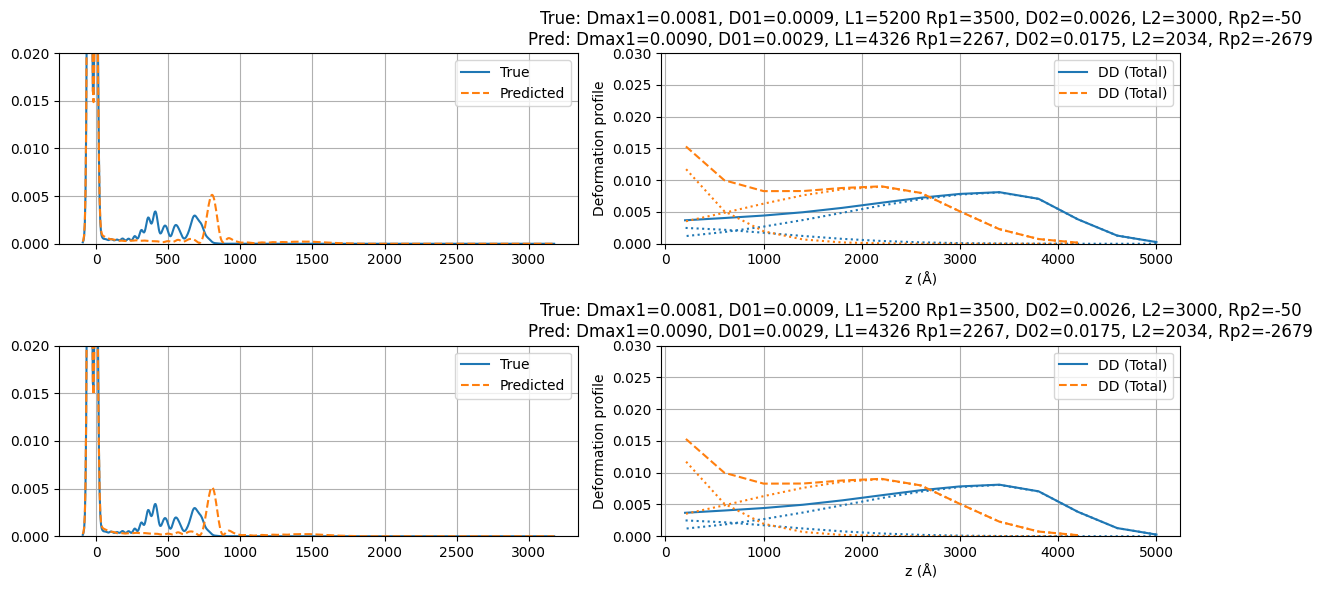

In [ ]:
# DDparam[0] = Dmax1
# DDparam[1] = D01
# DDparam[2] = L1
# DDparam[3] = Rp1
# DDparam[4] = D02
# DDparam[5] = L2
# DDparam[6] = Rp2

true_pred_pairs = [
    [[0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8], pred_values.tolist()],
    [[0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8], pred_values.tolist()],
]

print(true_pred_pairs)

def plot_profils(ax, profile, color, linestyle, pred=False):
    # L = dl * km
    # x_vals = [(L - dl * k + dl / 2) / 1e-8 for k in range(1, km + 1)]
    # ax.figure(figsize=(5, 3))
    ax.plot(profile.X, profile.total_Y, label='DD (Total)', color=color, linestyle=linestyle)
    # 'DDPL1 (Asymmetric Gaussian)'
    ax.plot(profile.X, profile.asymmetric_Y, label=None, linestyle=':', color=color)
    # 'DDPL2 (Decaying Gaussian)'
    ax.plot(profile.X, profile.decaying_Y, label=None, linestyle=':', color=color)
    ax.set_xlabel('z (Å)')
    ax.set_ylabel('Deformation profile')
    # ax.set_title('Deformation Profile Components')

fig, axes = plt.subplots(len(true_pred_pairs), 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.6)  # add vertical space between rows

for i, (true_params, pred_params) in enumerate(true_pred_pairs):
    print(f"True params: {true_params}, Pred params: {pred_params}")
    # add true_params to plot
    curve, profile_true = xrd.compute_curve_and_profile(
        array=true_params,
        dl=100e-8
    )
    
    axes[i, 0].plot(curve.X_DeltaTeta, curve.Y_R_vseZ, label="True")
    axes[i, 0].grid(True)
    axes[i, 0].set_ylim(0, 0.02)

    plot_profils(axes[i, 1], profile_true, 'C0', '-')

    curve, profile_pred = xrd.compute_curve_and_profile(
        array=pred_params,
        dl=100e-8
    )

    plot_profils(axes[i, 1], profile_pred, 'C1', '--')
    axes[i, 0].plot(curve.X_DeltaTeta, curve.Y_R_vseZ, label="Predicted", linestyle='dashed')
    axes[i, 1].set_title(f"True: {h.fparam(arr=true_params)}\nPred: {h.fparam(arr=pred_params)}")
    axes[i, 1].grid(True)
    axes[i, 1].set_ylim(0, 0.03)
    axes[i, 1].legend()
    axes[i, 0].legend()


plt.tight_layout()
plt.show()

## 7. Summary and Export

In [20]:
print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)
print()
print(f"Experimental data points: {len(exp_data)}")
print(f"Model input length: {EXPECTED_LENGTH}")
print(f"Peak intensity: {exp_data.max():.4e}")
print()
print("Predicted parameters:")
print(h.fparam(arr=pred_values))
print()
print("Individual values:")
for name, value in zip(PARAM_NAMES, pred_values):
    if name in ['L1', 'Rp1', 'L2', 'Rp2']:
        print(f"  {name}: {value*1e8:.0f} Å")
    else:
        print(f"  {name}: {value:.6f}")

ANALYSIS SUMMARY

Experimental data points: 360
Model input length: 650
Peak intensity: 8.0000e-02

Predicted parameters:
Dmax1=0.0090, D01=0.0029, L1=4326 Rp1=2267, D02=0.0175, L2=2034, Rp2=-2679

Individual values:
  Dmax1: 0.008990
  D01: 0.002902
  L1: 4326 Å
  Rp1: 2267 Å
  D02: 0.017456
  L2: 2034 Å
  Rp2: -2679 Å
